### Imports

In [0]:
import requests
import os
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, ArrayType, StructType, StructField, IntegerType, StringType
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
import seaborn as sns

### Funções

In [0]:
def metricas_iqr(df, coluna):
    """
    Calcula as métricas baseadas no intervalo interquartil (IQR) para identificar outliers em uma coluna de um DataFrame Spark.

    Essa função calcula os quartis (Q1, mediana, Q3) para a coluna especificada no DataFrame,
    define os limites inferior e superior para identificação de outliers com base no IQR, filtra os valores que são
    considerados outliers e exibe as métricas calculadas, como os quartis, o IQR e o número de outliers encontrados.

    Parâmetros:
        df (DataFrame): DataFrame Spark contendo a coluna a ser analisada.
        coluna (str): O nome da coluna numérica no DataFrame para a qual as métricas IQR serão calculadas.

    Retorna:
        DataFrame: Um DataFrame Spark contendo apenas os registros que são considerados outliers.

    Exibe:
        - Valor de Q1 (1º quartil), mediana e Q3 (3º quartil).
        - Valor do IQR (intervalo interquartil).
        - Limites inferior e superior calculados para definir os outliers.
        - Número total de valores considerados outliers.
    """
    q1, median, q3 = df.approxQuantile(coluna, [0.25, 0.5, 0.75], 0.01)
    iqr = q3 - q1 

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_outliers = df.filter((col(coluna) < lower_bound) | (col(coluna) > upper_bound))

    print(
        f"Q1: {q1}\n"
        f"Median: {median}\n"
        f"Q3: {q3}\n"
        f"IQR: {iqr}\n"
        f"Limites: inferior={lower_bound:.2f}, superior={upper_bound:.2f}\n"
        f"Número de outliers: {df_outliers.count()}"
    )
    
    return df_outliers

def teste_t(controle,target,coluna):
    """
    Realiza um teste T de Student para avaliar se há diferença significativa entre duas amostras em uma coluna específica.

    A função executa um teste T de Student (teste de hipótese) para comparar as médias de duas amostras (controle e target) 
    com base em uma coluna fornecida. O teste visa determinar se as diferenças entre os grupos são estatisticamente 
    significativas, assumindo variâncias desiguais (Welch's t-test).

    Parâmetros:
        controle (DataFrame): DataFrame Spark representando o grupo de controle.
        target (DataFrame): DataFrame Spark representando o grupo target.
        coluna (str): O nome da coluna que será comparada entre os grupos.
    """
    target_list = [row[coluna] for row in target.collect()]
    control_list = [row[coluna] for row in controle.collect()]
    
    stat, p_value = ttest_ind(control_list , target_list, equal_var=False)
    
    alpha = 0.05
    if p_value < alpha:
        print(p_value)
        print("Rejeita a hipótese nula: diferença significante.")
    else:
        print("Não rejeita a hipótese nula: sem diferença significante.")

### Reads

In [0]:
df_orders = spark.read.format("delta").load("/FileStore/iFood/dataset/orders_tratado/")
ab_test = spark.read.format("delta").load("/FileStore/iFood/dataset/ab_tratado")
df_consumer = spark.read.format("delta").load("/FileStore/iFood/dataset/consumer_tratado/")
restaurant = spark.read.format("delta").load("/FileStore/iFood/dataset/restaurant_tratado")

### Resultados

Para mensurar o sucesso da campanha foram definidos os seguintes indicadores:
- Frequência de pedidos
- Ticket Médio

Para campanhas de cupom é interessante observar a taxa de conversão 
(usuários que utilizaram cupom / usuários que o cupom foi disponibilizado). \
No entanto, os dados disponibilizados de usuários alocados no teste consistem nos mesmos usuários que fizeram os pedidos. 

In [0]:
df_metricas = (df_orders
    .groupBy("customer_id","is_target")
    .agg(
        countDistinct("order_id").alias("tt_order"),
        sum("order_total_amount").alias("tt_gasto_usuario")
    )
)

In [0]:
metricas = (df_metricas.groupBy("is_target") 
    .agg(
        count("customer_id").alias("total_usuarios"), 
        (sum("tt_order")).alias("tt_orders"),
        (sum("tt_gasto_usuario")).alias("receita_total"),
        mean("tt_order").alias("freq_pdd_usuario"),
        (sum("tt_gasto_usuario")/sum("tt_order")).alias("ticket_medio")
    ) 
)

In [0]:
metricas.display()

is_target,total_usuarios,tt_orders,receita_total,freq_pdd_usuario,ticket_medio
control,360514,1010670,4.81833808800085E7,2.8034140144349458,47.67469191725142
target,445895,1416584,6.761711055001299E7,3.1769452449567726,47.73251042649994


Ao analisar as métricas de sucesso estabelecidas, observamos uma diferença mais expressiva entre os grupos target e controle no que diz respeito à frequência de pedidos. Por outro lado, a diferença no ticket médio entre esses grupos é relativamente pequena.
Para validar a significância dessas observações, o próximo passo será realizar o teste t. Esse teste estatístico nos permitirá avaliar se as diferenças identificadas entre os grupos são estatisticamente significativas ou se podem ter ocorrido ao acaso, garantindo maior confiabilidade na interpretação dos resultados.

#### Teste t

- Hipótese Nula (H₀): A frequência de pedidos dos dois grupos é a mesma.
- Hipótese Alternativa (H₁): A frequência de pedidos dos dois grupos é diferente.

In [0]:
freq_target_group = df_metricas.filter(col("is_target") == "target").select("tt_order")
freq_control_group = df_metricas.filter(col("is_target") == "control").select("tt_order")

In [0]:
teste_t(controle = freq_control_group, target = freq_target_group, coluna = "tt_order")

0.0
Rejeita a hipótese nula: diferença significante.


- Hipótese Nula (H₀): O ticket médio dos dois grupos é o mesmo.
- Hipótese Alternativa (H₁): O ticket médio dos dois grupos é diferente.

In [0]:
tkt_target_group = df_orders.filter(col("is_target") == "target").select("order_total_amount")
tkt_control_group = df_orders.filter(col("is_target") == "control").select("order_total_amount")

In [0]:
teste_t(controle = tkt_control_group, target = tkt_target_group, coluna = "order_total_amount")

Não rejeita a hipótese nula: sem diferença significante.


Os resultados evidenciam que a estratégia de oferecer cupons foi eficaz para incentivar os clientes a realizar mais pedidos (maior frequência de compras). Por outro lado, o cupom não teve um impacto substancial no ticket médio. A ação foi mais eficaz para motivar o volume de transações do que para aumentar o valor das compras individuais.

### Viabilidade financeira

Para analisar a viabilidade financeira do teste realizado, foi calculado o ROI da campanha. \
Foram estabelecidas as seguintes premissas: 
- Cupom Especial: R$20
- Taxa iFood: 20%

**ROI:** \
Para o cálculo da receita incremental no ROI, é necessário considerar a diferença no tamanho da base do target e do controle. Desse modo, a receita incremental é calculada a partir de: \
((Receita por usuário target) - (Receita por usuário controle)) * número de usuários 
target \
O resultado obtido de ROI para essa campanha foi de -0,3. Ou seja: os ganhos gerados pela campanha _não foram suficientes_ para cobrir os custos envolvidos.
\
\
Segue abaixo o gráfico Cupom vs. ROI.



In [0]:
df_metricas_filtred = (
    metricas
    .select(
    'total_usuarios',
    'receita_total',
    lit(0.2).alias('taxa_ifood')
    )
)

metricas_control = df_metricas_filtred.filter(col("is_target") == "control").drop("is_target")
metricas_target = df_metricas_filtred.filter(col("is_target") == "target").drop("is_target")

metricas_control = metricas_control.select([col(c).alias(f"{c}_control") for c in metricas_control.columns])
metricas_target = metricas_target.select([col(c).alias(f"{c}_target") for c in metricas_target.columns])

metricas_pivotado = metricas_control.crossJoin(metricas_target)

In [0]:
schema_cupons = StructType([StructField("cupom", IntegerType(), True)])

data_cupons = [(valor,) for valor in [10, 15, 20, 25, 30, 35]]

df_cupons = spark.createDataFrame(data_cupons, schema=schema_cupons)

In [0]:
df_resultado = metricas_pivotado.crossJoin(df_cupons)

In [0]:
roi = (df_resultado
    .drop('taxa_ifood_target')
    .withColumnRenamed('taxa_ifood_control', 'taxa_ifood')
    .withColumn('receita_user_target', (1 - col('taxa_ifood')) * col('receita_total_target') / col('total_usuarios_target'))
    .withColumn('receita_user_control', (1 - col('taxa_ifood')) * col('receita_total_control') / col('total_usuarios_control'))
    .withColumn('receita_incremental', (col('receita_user_target')-col('receita_user_control'))*col('total_usuarios_target'))
    .withColumn('custo', col('total_usuarios_target')*col('cupom'))
    .withColumn('ROI', (col('receita_incremental')-col('custo'))/col('custo'))
    .select('cupom','ROI')
)

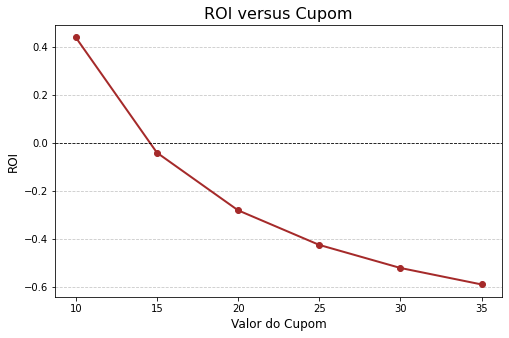

In [0]:
df_roi = roi.toPandas()

plt.figure(figsize=(8, 5))
plt.plot(df_roi['cupom'], df_roi['ROI'], color='brown', marker='o', linestyle='-', linewidth=2)

plt.title("ROI versus Cupom", fontsize=16)
plt.xlabel("Valor do Cupom", fontsize=12)
plt.ylabel("ROI", fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Considerando as condições nas quais o teste ocorreu, o ROI seria positivo apenas para cupons abaixo de R$15.

### Oportunidade de melhoria: 

#### Testar elasticidade

- **Objetivo** \
Avaliar a elasticidade dos valores de cupons para identificar o ponto ideal em que, ao reduzir o custo do benefício, o impacto em métricas-chave do negócio seja minimizado ou até otimizado.

- **Descrição do Teste** \
Serão criados n grupos (Exemplo: Controle + 3 grupos de teste) onde cada grupo irá receber cupons com valores diferentes.

- **Métricas de sucesso** \
Conversão \
Frequência de pedidos \
Custo por pedido \
Ticket médio
